<a href="https://colab.research.google.com/github/haydenkirkeide/Data-Mining-Final-Project/blob/main/K_Means_ANON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial Data Head:
          age employed membership membership_start       freq avg_cost  \
ID                                                                       
#001  18 - 25       ft        yes             2023    monthly     $150   
#002  18 - 25       no         no                -      never        -   
#003  18 - 25       no         no              NaN     Yearly      $50   
#004  18 - 25       pt         no              NaN    monthly      180   
#005  18 - 25       pt         no             2024  quarterly     1000   

      avg_time_spent  
ID                    
#001   About an hour  
#002               -  
#003  40-ish minutes  
#004      60 minutes  
#005              3h  


Imputing avg_cost_num NaNs with median: 120.0
Imputing avg_time_spent_min NaNs with median: 50.0
Imputing freq_encoded NaNs with median: 3.0

Features for Clustering (First 5 Rows):
      freq_encoded  avg_cost_num  avg_time_spent_min
ID                                                  
#001       

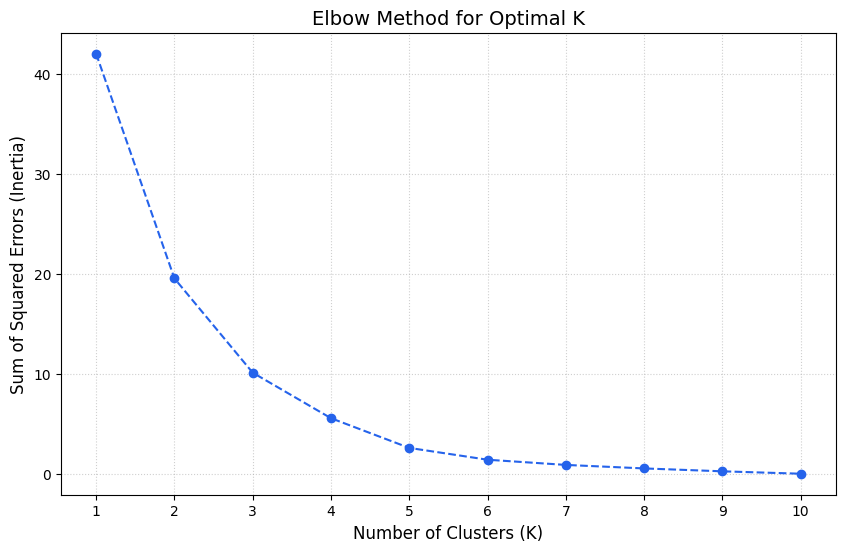

Chosen K based on visual inspection of the elbow method: 3


--- CLUSTER PROFILES (Quantitative Features) ---
Cluster Centroids (Original Feature Scale):
        Dominant_Freq  Avg Cost ($)  Avg Time Spent (min)
Cluster                                                  
0           quarterly    117.777778             47.222222
1              weekly    207.500000             35.000000
2           quarterly   1000.000000            180.000000


--- CLUSTER PROFILES (Demographic Attributes) ---
Distribution of 'age' by Cluster (Mode/Counts):
Mode for age:
Cluster
0    18 - 25
1    18 - 25
2    18 - 25
Name: age, dtype: object

Top 3 Categories for age:
Cluster 0:
  - 18 - 25: 88.9%
  - 26 - 32: 11.1%
Cluster 1:
  - 18 - 25: 100.0%
Cluster 2:
  - 18 - 25: 100.0%
------------------------------
Distribution of 'employed' by Cluster (Mode/Counts):
Mode for employed:
Cluster
0    no
1    pt
2    pt
Name: employed, dtype: object

Top 3 Categories for employed:
Cluster 0:
  - no: 55.6%
  - pt: 33

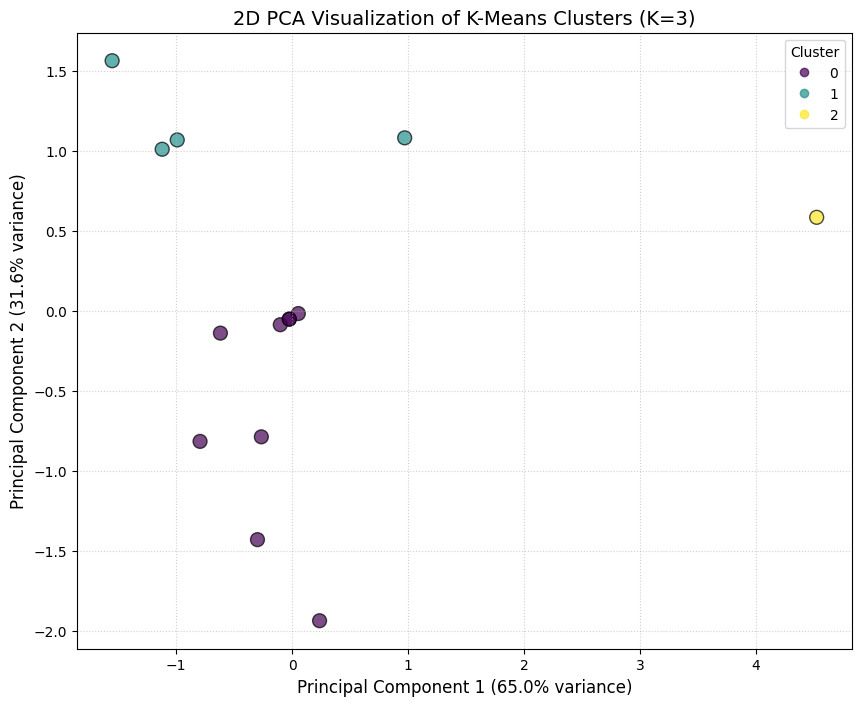


Total Variance Explained by PC1 and PC2: 96.6%

--- Summary of First 5 Clustered Records ---
           freq avg_cost  avg_time_spent      age employed  Cluster
ID                                                                 
#001    monthly     $150   About an hour  18 - 25       ft        0
#002      never        -               -  18 - 25       no        0
#003     Yearly      $50  40-ish minutes  18 - 25       no        0
#004    monthly      180      60 minutes  18 - 25       pt        0
#005  quarterly     1000              3h  18 - 25       pt        2


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- 1. Data Loading and Setup ---
# Using the survey data which contains demographic and aggregated shopping metrics.
file_path = "OPT ANON Preliminary Survey - Sheet1.csv"
try:
    data = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please ensure the file is correctly uploaded.")
    exit()

# Set 'ID' as index for easier analysis later
data = data.set_index('ID')
print("Initial Data Head:")
print(data.head())
print("\n" + "="*50 + "\n")


# --- 2. Data Cleaning and Feature Engineering ---

# Define the features for clustering: shopping attributes
features_to_cluster = ['freq', 'avg_cost', 'avg_time_spent']

# 2.1 Clean 'avg_cost'
def clean_cost(cost):
    """Converts cost strings (e.g., '$150 ', '1000', '-', 'NA') to float."""
    if pd.isna(cost) or str(cost).strip() in ['-', 'NA', 'N/A', 'No', 'no', 'nan']:
        return np.nan
    try:
        # Remove '$', ',', and whitespace
        return float(str(cost).replace('$', '').replace(',', '').strip())
    except ValueError:
        return np.nan

data['avg_cost_num'] = data['avg_cost'].apply(clean_cost)


# 2.2 Clean 'avg_time_spent'
def clean_time(time_str):
    """Converts time strings (e.g., '3h', '20min', 'About an hour') to total minutes (float)."""
    if pd.isna(time_str) or str(time_str).strip() in ['-', 'NA', 'N/A', 'No', 'no', 'nan']:
        return np.nan

    time_str = str(time_str).lower().strip()

    # Simple direct minute conversions
    if 'min' in time_str or 'minutes' in time_str or 'mins' in time_str:
        # Extract numbers, e.g., '40-ish minutes' -> 40
        time_str = ''.join(filter(str.isdigit, time_str))
        if time_str:
            return float(time_str)

    # Hour conversions
    elif 'h' in time_str or 'hour' in time_str:
        # Check for 'About an hour' or '60 minutes' equivalent
        if any(w in time_str for w in ['hour', '60']):
            return 60.0
        # Check for explicit hour values like '2 hours'
        try:
            # Extract numbers for '2h' or '2 hours'
            time_val = float(''.join(filter(str.isdigit, time_str)))
            return time_val * 60
        except ValueError:
            return 60.0 # Defaulting to 60 min if parsing fails (e.g., '30 (minutes)' should be caught by minute check)

    # Last resort check for pure numbers (assuming they are in minutes)
    try:
        return float(time_str)
    except ValueError:
        return np.nan # If all else fails

data['avg_time_spent_min'] = data['avg_time_spent'].apply(clean_time)


# 2.3 Ordinal Encoding for 'freq'
# Define an order for shopping frequency
freq_order = {
    'never': 0,
    'Yearly': 1,
    'quarterly': 2,
    'monthly': 3,
    'biweekly': 4,
    'weekly': 5,
    'mult_per_week': 6
}
# Map the values, coercing unknown or missing values to NaN
data['freq_encoded'] = data['freq'].str.strip().map(freq_order).fillna(np.nan)


# 2.4 Handle Missing Values (Imputation)
# Impute NaNs with the median value for each new numerical column
for col in ['avg_cost_num', 'avg_time_spent_min', 'freq_encoded']:
    median_val = data[col].median()
    data[col] = data[col].fillna(median_val)
    print(f"Imputing {col} NaNs with median: {median_val}")

# Prepare the final feature matrix X
X = data[['freq_encoded', 'avg_cost_num', 'avg_time_spent_min']].copy()
print("\nFeatures for Clustering (First 5 Rows):")
print(X.head())
print("\n" + "="*50 + "\n")


# --- 3. Feature Scaling ---
# K-means is sensitive to the scale of the features, so we standardize them.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)


# --- 4. Determine Optimal K (The Elbow Method) ---
# We use the Sum of Squared Errors (SSE) to find the 'elbow' point.
sse = {}
# Test K from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_df)
    sse[k] = kmeans.inertia_ # Inertia is the SSE

# Plotting the Elbow Method result
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o', linestyle='--', color='#2563EB')
plt.xlabel("Number of Clusters (K)", fontsize=12)
plt.ylabel("Sum of Squared Errors (Inertia)", fontsize=12)
plt.title("Elbow Method for Optimal K", fontsize=14)
plt.xticks(range(1, 11))
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# *Note: Based on typical small dataset results, K=3 or K=4 is often a good starting point.*
# We will choose K=3 for demonstration.
K_OPTIMAL = 3
print(f"Chosen K based on visual inspection of the elbow method: {K_OPTIMAL}")
print("\n" + "="*50 + "\n")


# --- 5. K-Means Clustering ---
kmeans_final = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init=10)
data['Cluster'] = kmeans_final.fit_predict(X_scaled_df)


# --- 6. Cluster Analysis and Interpretation ---

print("--- CLUSTER PROFILES (Quantitative Features) ---")
# Analyze the mean of the original, unscaled features for each cluster
cluster_means = data.groupby('Cluster')[['freq_encoded', 'avg_cost_num', 'avg_time_spent_min']].mean()

# To make 'freq_encoded' readable again, we invert the mapping for display
reverse_freq_map = {v: k for k, v in freq_order.items()}
cluster_means['Dominant_Freq'] = cluster_means['freq_encoded'].round().astype(int).map(reverse_freq_map)
cluster_means = cluster_means.rename(columns={'avg_cost_num': 'Avg Cost ($)',
                                              'avg_time_spent_min': 'Avg Time Spent (min)'})
print("Cluster Centroids (Original Feature Scale):")
print(cluster_means[['Dominant_Freq', 'Avg Cost ($)', 'Avg Time Spent (min)']])
print("\n" + "="*50 + "\n")

print("--- CLUSTER PROFILES (Demographic Attributes) ---")
# Analyze the distribution of demographic/categorical attributes within each cluster
for col in ['age', 'employed', 'membership']:
    print(f"Distribution of '{col}' by Cluster (Mode/Counts):")

    # Calculate mode (most frequent category) for each cluster
    mode_series = data.groupby('Cluster')[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'N/A')

    # Calculate counts for all categories
    counts_df = data.groupby('Cluster')[col].value_counts(normalize=True).mul(100).rename('Percent').reset_index()

    print(f"Mode for {col}:")
    print(mode_series)
    print(f"\nTop 3 Categories for {col}:")
    for cluster_id in range(K_OPTIMAL):
        top_cats = counts_df[counts_df['Cluster'] == cluster_id].nlargest(3, 'Percent')
        print(f"Cluster {cluster_id}:")
        for index, row in top_cats.iterrows():
            print(f"  - {row[col]}: {row['Percent']:.1f}%")
    print("-" * 30)


# --- 7. Visualization (PCA) ---
# Reduce the 3-dimensional scaled data to 2 dimensions for plotting
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled_df)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=data.index)
pca_df['Cluster'] = data['Cluster']

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'],
                      c=pca_df['Cluster'],
                      cmap='viridis',
                      edgecolor='k',
                      s=100,
                      alpha=0.7)
plt.title(f'2D PCA Visualization of K-Means Clusters (K={K_OPTIMAL})', fontsize=14)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
plt.legend(*scatter.legend_elements(), title="Cluster", loc="upper right")
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# Print the variance explained by the first two components
print(f"\nTotal Variance Explained by PC1 and PC2: {pca.explained_variance_ratio_.sum()*100:.1f}%")

print("\n--- Summary of First 5 Clustered Records ---")
print(data[['freq', 'avg_cost', 'avg_time_spent', 'age', 'employed', 'Cluster']].head())